In [2]:
import pandas as pd
from utils import get_all_csv_filepaths
from typing import Generator

chunk_size = 10000
file_paths = get_all_csv_filepaths()[0]


def get_chunks(file_path: str, chunk_size: int) -> Generator[pd.DataFrame, None, None]:
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    for chunk in chunks:
        yield chunk


chunks = get_chunks(file_paths, chunk_size)

# 初始化一个空的DataFrame来存储最终结果
filtered_df = pd.DataFrame()

In [3]:
# 过滤出“案件类型”列中的刑事案件和民事案件
for chunk in chunks:
    filtered_chunk = chunk[chunk["案件类型"].isin(["刑事案件", "民事案件"])]
    filtered_df = pd.concat([filtered_df, filtered_chunk], ignore_index=True)

In [4]:
# 删除”审理程序“中的空行
filtered_df = filtered_df[filtered_df["审理程序"].notnull()]

# 过滤出“审理程序”包含“一审”的行
filtered_df = filtered_df[filtered_df["审理程序"].str.contains("一审")]

In [5]:
# 删除“文书内容”列中的空行
filtered_df = filtered_df[filtered_df["文书内容"].notnull()]

# 提取“文书内容”列中审判法院的所在区县，匹配第一个“人们法院”前的所以文本
filtered_df["审判法院所在地址"] = filtered_df["文书内容"].str.extract(r"(.+?)人民法院")

In [6]:
from utils import ChineseDate2EnglishDate

# 提取“文书内容”列中的判决时间，匹配“二〇XX年X/XX月X/XX/XXX日”格式的日期
filtered_df["判决时间"] = filtered_df["文书内容"].str.extract(
    r"(二〇[一二三四五六七八九十〇]{2}年[一二三四五六七八九十〇]{1,2}月[一二三四五六七八九十〇]{1,3}日)"
)

# 删除“判决时间”列中的空行
filtered_df = filtered_df[filtered_df["判决时间"].notnull()]


# 将“判决时间”列转换成日期格式
filtered_df["判决时间"] = filtered_df["判决时间"].apply(ChineseDate2EnglishDate)

# 将“判决时间”列的时间格式转换成python的时间格式
filtered_df["判决时间"] = pd.to_datetime(
    filtered_df["判决时间"], format="%Y-%m-%d", errors="coerce"
)

# 删除“判决时间”列中的空行
filtered_df = filtered_df[filtered_df["判决时间"].notnull()]


判决时间
2000         5
2001         1
2002         4
2003         4
2004         2
2005         5
2006         4
2007         3
2008         2
2009         7
2010         8
2011         7
2012        37
2013        14
2014        32
2015        30
2016       115
2017       140
2018       168
2019       231
2020      7309
2021    367528
2022         3
2027         1
2028         1
2042         1
Name: count, dtype: int64

判决时间
1     367548
2        133
3        106
4        103
5        106
6        160
7        256
8        358
9        488
10       393
11       780
12      5231
Name: count, dtype: int64

Frequency Table:
      Cases per Year  Cases per Month
判决时间                                 
1                NaN         367548.0
2                NaN            133.0
3                NaN            106.0
4                NaN            103.0
5                NaN            106.0
6                NaN            160.0
7                NaN            256.0
8                NaN            358.0
9                NaN            488.0
10               NaN            393.0
11               NaN            780.0
12               NaN           5231.0
2000             5.0              NaN
2001             1.0              NaN
2002             4.0              NaN
2003             4.0              NaN
2004             2.0              NaN
2005             5.0              NaN
2006             4.0              NaN
2007             3.0              NaN
2008             2.0              NaN
2009             7.0              NaN
2010             8.0              NaN
2011             7.0             

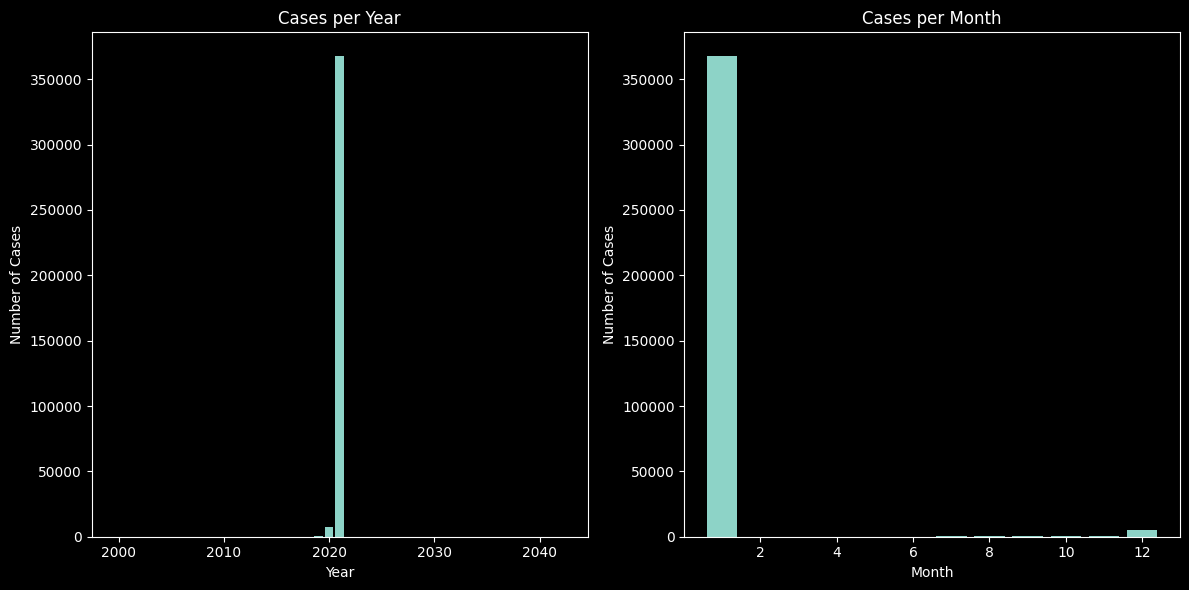

In [7]:
import matplotlib.pyplot as plt

# 根据“判决时间”列统计每年每个月份的案件数量
display(filtered_df["判决时间"].dt.year.value_counts().sort_index())
display(filtered_df["判决时间"].dt.month.value_counts().sort_index())

# 统计每年和每月的案件数量
cases_per_year = filtered_df["判决时间"].dt.year.value_counts().sort_index()
cases_per_month = filtered_df["判决时间"].dt.month.value_counts().sort_index()

# 创建频率表格
frequency_table = pd.DataFrame({
    'Cases per Year': cases_per_year,
    'Cases per Month': cases_per_month
})

# 打印频率表格
print("Frequency Table:")
print(frequency_table)

# 可视化每年和每月的案件数量
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(cases_per_year.index, cases_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.title('Cases per Year')

plt.subplot(1, 2, 2)
plt.bar(cases_per_month.index, cases_per_month.values)
plt.xlabel('Month')
plt.ylabel('Number of Cases')
plt.title('Cases per Month')

plt.tight_layout()
plt.show()